In [35]:
import numpy as np
import torch
import torch.nn as nn
import glob
import datetime
import random
import re
import pickle
datapath = "./data/rel_int/"
#import wandb


from matplotlib import pyplot as plt
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from scipy.special import voigt_profile as voigt

In [51]:
#Pre-process database to dict. element key with array of [wavelength,relative intensity]
path="./data/slim_db/"
filenames = glob.glob(path + '/*')
atom_dict = {}  #of form {element:ndarray[[wavelength, rel_intensity]]}
#Available elements, starting with first 30
el_include = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", "Na", "Mg",
            "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca", "Sc", "Ti", "V", "Cr",
            "Mn", "Fe", "Co", "Ni", "Cu", "Zn"]
#database missing data for these elements, need to check source?
no_lines = ["Pr", "Es", "Rn", "Pu"] 

#check basic setup for inclusion of unavailable elements
for el in no_lines:
    if el in el_include:
        raise ValueError("Trying to include an element with no spectral data")

for filename in filenames:
    #get element from filename
    m = re.search('^.*slim_db/([A-Za-z]+).npy$', filename)
    element = m[1]
    
    if element in no_lines or element not in el_include:
        #print('Skipping: ', element)
        continue
    #print('Processing: ', element)
    
    #load file data into ndarray
    #'element', 'sp_num', 'obs_wl_vac(nm)', 'ritz_wl_vac(nm)', 'intens', 'gA(s^-1)', 'Acc', 'Ei(eV)', 'Ek(eV)', 'conf_i',
    #'term_i', 'J_i', 'conf_k', 'term_k', 'J_k', 'g_i', 'g_k', 'Type', 'tp_ref', 'line_ref'
    filedata = np.load(filename)
    #drop headers, keep only wavelength(3), g_a(5) and g_k(16)
    filedata = filedata[1:,[3,5,16]]
    #note this is string data at this point, which may be helpful through the grouping stage!
    #type(filedata[0,0]) #numpy.str_
    #convert the g_A data to A_ki data which is ~ to intensity
    #However, some wavelengths have '+' so clean that up now. Using loop, look for native array op
    for i in range(filedata.shape[0]):
        filedata[i,0] = re.search('[0-9]+.[0-9]+',filedata[i,0])[0]

    wvlengths = filedata[:,0] #array of strings in numeric format
    filedata[:,1] = (filedata[:,1].astype(float) / filedata[:,2].astype(float))
    #drop the g_k col
    filedata = filedata[:,0:2]
    #note everything is still string data because that's the datatype of the array! will change later
    #next we aggregate by unique wavelength (e.g Li has multiple rows/probs at same wl)
    #clever example here of using np.split to group
    #https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function
    #sort by wavelength
    filedata = filedata[filedata[:,0].astype(float).argsort()]
    #find the breakpoint indices which define each group/wavelength, skip first value
    unique_ind = np.unique(filedata[:, 0], return_index=True)[1][1:]
    wavegroups = np.split(filedata[:,1], unique_ind)#list of arrays. Array contains intensity values to sum for wl
    #sum the intensities at each distinct wl
    wavesums = np.array([np.sum(intens_arr.astype(float)) for intens_arr in wavegroups])
    #add the first wavelength index back to array of unique value indices
    unique_ind = np.append(0, unique_ind)
    if len(unique_ind) == len(wavesums):
        atom_dict[element] = np.column_stack((filedata[:,0][unique_ind].astype(float),
                                                wavesums.astype(float)/np.sum(wavesums.astype(float))))

#persist the data for ongoing usage
#datapath = "./data/rel_int/"
#with open(datapath + 'top30_spec.pickle', 'wb') as f:
# Pickle the relative intensity spectra with default protocol (4 as of py3.8)
#    pickle.dump(atom_dict, f)

#To load in other modules at top level of repo
#import pickle
#datapath = "./data/rel_int/"
#with open(datapath + 'top30_spec.pickle', 'rb') as f:
#    atom_dict = pickle.load(f)

In [67]:
#Specta viewer data
with open(datapath + 'top30_spec.pickle', 'rb') as f:
    atom_dict = pickle.load(f)

<function matplotlib.pyplot.show(close=None, block=None)>

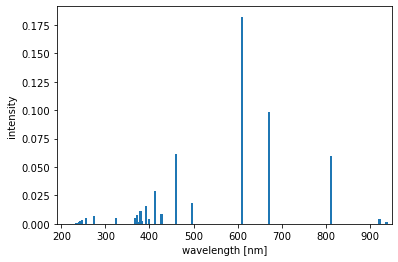

In [69]:
#update element to see atomic spectra
elem = "Li"
x_spec=atom_dict[elem][:,0]
y_spec=atom_dict[elem][:,1]
plt.bar(x=x_spec, height = y_spec, width=5)
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950]) #note data may go beyond this
plt.show


In [6]:
class spectrum_maker():
    """ generates LPS spectra """
    
    def __init__(self):
        self.elements = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 
        'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 
        'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 
        'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 
        'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 
        'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 
        'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Uut', 'Fl', 'Uup', 'Lv', 'Uus', 'Uuo']
        self.stable_elements = self.elements[:92]
        self.amt = np.zeros(len(self.stable_elements))
        self.el_dict = dict(zip(self.stable_elements, self.amt))
        #make data location an environment variable when creating modules
        
        with open(datapath + 'top30_spec.pickle', 'rb') as f:
            self.atom_dict = pickle.load(f)
        

    def peak_maker(self,
    element,
    inc=1,
    w_lo=190,
    w_hi=950,
    sigma=1,
    gamma=1,
    shift=True,
    shift_type='sys',
    shift_mean=0,
    height=True,
    height_type='random',
    height_mean=0,
    height_mag=0.001,
    artifact=True,
    art_type='square',
    art_mag=0.01,
    noise=True,
    noise_type='Gaussian',
    snr=10,
    plot=True):
        
        peak_loc = self.atom_dict[element][:,0]
    
        if plot:
        #    plot histogram of element intensities
             plt.hist(self.atom_dict[element])
             plt.xlabel('normalized intensity [au]')
             plt.ylabel('quantity')
             plt.show
        
        peak_count = len(rel_int)
        wave = np.arange(w_lo, w_hi, inc)
        
        # jitter peak positions and intensities
        if shift:
            if shift_type=='sys': # apply systematic peak shift
                peak_loc = peak_loc + shift_mean
            if shift=='random': # apply random peak shift
                mag = shift_mean * np.random.rand(peak_count)
                peak_loc = peak_loc + mag
        
        if height:
            if height_type=='random':
                h_mult = np.random.rand(peak_count) + 0.5
                rel_int = h_mult * rel_int
                rel_int = rel_int / np.sum(rel_int, axis=0)
            if height_type=='lin':
                h_mult = height_mag*peak_loc + height_mean
                rel_int = h_mult * rel_int
        
        # create peaks with defined Voigt profiles from peak location and intensities derived from database
        peaks = np.array([a * voigt(wave - x, sigma, gamma) for a, x in zip(rel_int, peak_loc)])
        spec = np.sum(peaks, axis=0)
        
        if plot:
            plt.plot(wave, spec)
            plt.xlabel('wavelength [nm]')
            plt.ylabel('intensity')
            plt.xlim([190, 950])
            plt.show
        
        return wave, spec    
    
    def make_spectra(self, 
        fracs,
        inc=1,
        w_lo=190, # lower limit of spectrum
        w_hi=950, # upper limit of spectrum
        artifact=True, # flag to include spectral artifacts ('constant', 'square', or 'Gaussian')
        art_type=['square', 'Gaussian'], # types of artifacts to be included - must be a list for now
        art_mag=0.1, # relative magnitude of artifact to spectrum intensity
        sigma=True, # noise 
        mu=True,
        a=True,
        noise=True, # noise flag
        noise_type='Gaussian', # noise type
        snr=10):
        
        specs = np.argwhere(fracs)
        self.el_dict = dict(zip(self.stable_elements, fracs))
        spec_array_len = np.count_nonzero(specs) + 1
        
        spec_array = np.zeros((len(self.stable_elements), int((w_hi-w_lo)*inc))) # preallocate full spectral data array
        
        # --- loop over elements for which spectra will be generated
        # --- this could be improved
        #TODO this zip may only work with continuous non-zero entries from start of fracs
        #example, see the indexing is misaligned with corresponding element. Zip combines the first n elements of each iterable into tuple
        #In [88]: for i,j in zip(np.argwhere([0,0,0,0.5,0.5,0,0]),el_dict):
        #     print(i,J) 
        #[3] H
        #[4] He
        
        for i, j in zip(specs, self.el_dict):
            _, spec_array[i] = self.el_dict[j] * np.array(peak_maker(j, gamma=.1, sigma=.1, plot=False))
        
        wave = np.arange(w_lo, w_hi, inc)
        
        # --- sum elemental spectra and normalize
        # --- best normalization for network performance?
        spec = np.sum(spec_array, axis=0)
        spec /= np.sum(spec)
        
        maximum = np.max(spec)
        
        # --- add artifacts
        art = np.zeros(len(spec))
        if artifact:
            if any([i=='const' for i in art_type]):
                art += art_mag * maximum
                
            if any([i=='square' for i in art_type]):
                lim = np.sort(np.random.choice(wave, 2))
                idx = (wave>lim[0]) * (wave<lim[1])
                sq_loc = np.where(idx)[0]
                art_scale = art_mag * maximum
                art[sq_loc] += art_scale
                
            if any([i=='Gaussian' for i in art_type]):
                if sigma:
                    sigma = (w_hi-w_lo)*0.5
                if mu:
                    mu = np.random.randint(w_lo,w_hi)
                bg = 100 * np.random.rand() * maximum * 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (wave - mu)**2 / (2 * sigma**2))
                art += bg
                
        spec += art
        #consider just returning art as separate obj and keep spec_array context as 92 elements
        spec_array = np.append(spec_array, np.expand_dims(art, 0), axis=0)
        
        # --- add noise
        noi = np.zeros(len(spec))
        if noise:
            if noise_type=='Gaussian':
                noi += np.random.normal(0, 1/snr**2, len(noi))
        
        spec += noi
        #same idea, perhaps keep noise separate return
        spec_array = np.append(spec_array, np.expand_dims(noi, 0), axis=0)
        
        return wave, spec, spec_array
    
    def batch_spectra(self, 
        fracs,
        inc=1,
        w_lo=190, # lower limit of spectrum
        w_hi=950, # upper limit of spectrum
        artifact=True, # flag to include spectral artifacts ('constant', 'square', or 'Gaussian')
        art_type=['square', 'Gaussian'], # types of artifacts to be included - must be a list for now
        art_mag=0.1, # relative magnitude of artifact to spectrum intensity
        sigma=True, # noise 
        mu=True,
        a=True,
        noise=True, # noise flag
        noise_type='Gaussian', # noise type
        snr=10,
        batch=16):
        
        bt_data = np.zeros((batch, int((w_hi-w_lo)*inc)))
        bv_data = np.zeros((batch, int(len(fracs)+2), int((w_hi-w_lo)*inc)))
        
        for i in np.arange(batch):
            wave, bt_data[i], bv_data[i] = self.make_spectra(fracs, 
                                                       inc, 
                                                       w_lo, 
                                                       w_hi, 
                                                       artifact,
                                                       art_type,
                                                       art_mag,
                                                       sigma,
                                                       mu,
                                                       a,
                                                       noise,
                                                       noise_type,
                                                       snr)
        bt_data = torch.Tensor(bt_data)
        bv_data = torch.Tensor(bv_data)
        
        return wave, bt_data, bv_data       
        

In [7]:
def syn_data_1():
    nel = 5
    npad = 92 - nel
    fracs = np.pad(np.random.rand(nel), (0, npad))
    fracs /= np.sum(fracs)
    
    return fracs

In [9]:
class data_loader():
    """ load data filenames from a path, spilt in to training and validation, and randomize for new epochs """
    
    def __init__(self, path):
        self.filenames = glob.glob(path + '/*')
        self.filenumbers = [i.split('/')[-1].split('.npy')[0].split('_')[1] for i in self.filenames]
        self.filedict = dict(zip(self.filenumbers, self.filenames))
        
    def tvdata(self, tval=0.75):
        # training data
        td = random.choices(self.filenumbers, k=int(len(self.filenumbers) * tval))
        tdl = [self.filedict[x] for x in td]
        
        # validation data
        vd = set(self.filenumbers) ^ set(td)
        vdl = [self.filedict[x] for x in vd]
        
        return vdl, tdl
    
    def rand_edata(self, epoch_num=0):
        pass
    

In [7]:
# test_dclass = data_loader()
# test_vval, test_tval = test_dclass.tvdata()

In [10]:
def double_conv(in_c, out_c, kernel_size=6):
    conv = nn.Sequential(
        nn.Conv1d(in_c, out_c, kernel_size=kernel_size),
        nn.ReLU(inplace=True),
        nn.Conv1d(out_c, out_c, kernel_size=kernel_size),
        nn.ReLU(inplace=True))
        
    return conv

def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[-1]
    tensor_size = tensor.size()[-1]
    delta = abs(target_size - tensor_size)
    
    if delta % 2 > 0:
        delta = delta // 2 
        return tensor[:, :, delta:(tensor_size - delta - 1)]
    else:
        delta = delta // 2
        return tensor[:, :, delta:tensor_size - delta]

In [11]:
class LIBSUNet(nn.Module):
    """ UNet for LIBS data """
    def __init__(self):
        super(LIBSUNet, self).__init__()
        
        el = torch.tensor([0,1,2,4,6,8,16]) * 94 # 94 output channels corresponding to 92 elements + artifacts + noise 
        
        self.max_pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(1, 94)
        self.down_conv_2 = double_conv(94, 188)
        self.down_conv_3 = double_conv(188, 376)
        self.down_conv_4 = double_conv(376, 752)
        self.down_conv_5 = double_conv(752, 1504)
        
        
        self.up_trans_1 = nn.ConvTranspose1d(
            in_channels=1504,
            out_channels=752,
            kernel_size=2,
            stride=2)
        self.up_conv_1 = double_conv(1504, 752)
        
        self.up_trans_2 = nn.ConvTranspose1d(
            in_channels=752,
            out_channels=376,
            kernel_size=2,
            stride=2)
        self.up_conv_2 = double_conv(752, 376)
        
        self.up_trans_3 = nn.ConvTranspose1d(
            in_channels=376,
            out_channels=188,
            kernel_size=2,
            stride=2)
        self.up_conv_3 = double_conv(376, 188)
        
        self.up_trans_4 = nn.ConvTranspose1d(
            in_channels=188,
            out_channels=94,
            kernel_size=2,
            stride=2)
        self.up_conv_4 = double_conv(188, 94)
        
        self.out = nn.Linear(720, 720)
        
    def forward(self, image):
        #encoder
        x1 = self.down_conv_1(image)
        x2 = self.max_pool(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool(x7)
        x9 = self.down_conv_5(x8)
        
        #decoder
        x = self.up_trans_1(x9)
        y = crop_img(x7, x)
        x = self.up_conv_1(torch.cat([x, y], 1))
        x = self.up_trans_2(x7)
        y = crop_img(x5, x)
        x = self.up_conv_2(torch.cat([x, y], 1))
        x = self.up_trans_3(x5)
        y = crop_img(x3, x)
        x = self.up_conv_3(torch.cat([x, y], 1))
        x = self.up_trans_4(x3)
        y = crop_img(x1, x)
        x = self.up_conv_4(torch.cat([x, y], 1))
        y = self.out(x)
        
        return y

torch.Size([1, 760])

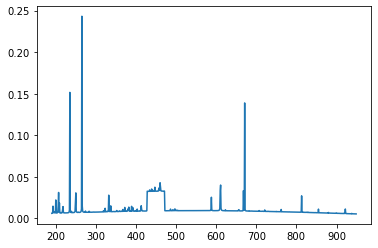

In [12]:
test_data = spectrum_maker().batch_spectra(syn_data_1(), batch=1, snr=np.random.randint(low=1, high=1000))
plt.plot(test_data[0], test_data[1][0])
np.shape(test_data[1])
#test_data = torch.Tensor(test_data[1][0])[None, None,:]

In [1]:
if __name__ == "__main__":
    model = LIBSUNet()
    #print(model(test_data))
    #print(torch.Tensor.size(model(test_data)))

NameError: name 'LIBSUNet' is not defined

In [14]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    batch_size = 16
    num_batch = 50
    
    for i, data in enumerate(np.arange(num_batch)):
       
        _, inputs, labels = spectrum_maker().batch_spectra(syn_data_1(), batch=batch_size, snr=np.random.randint(low=10, high=1000))
        
        inputs = inputs[:, None, :]
        #labels = labels

        # Zero gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels[:,:,20:-20])
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 10 == 1:
            last_loss = running_loss / 50 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * batch_size + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [15]:
# Initializing in a separate cell so we can easily add more epochs to the same run

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
epoch_number = 0

EPOCHS = 2

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(np.arange(15)):
        # Every data instance is an input + label pair
        _, vinputs, vlabels = spectrum_maker().make_spectra(syn_data_1(), snr=np.random.randint(low=10, high=1000))
        vinputs = torch.Tensor(vinputs[None, None, :])
        vlabels = torch.Tensor(vlabels[None, :])
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels[:,:,20:-20])
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 2 loss: 2.456051530316472e-05
  batch 12 loss: 0.00011880441335961223
  batch 22 loss: 0.00010805971105583012
  batch 32 loss: 9.737900807522238e-05
  batch 42 loss: 8.885879069566726e-05
LOSS train 8.885879069566726e-05 valid 0.00039672147249802947
EPOCH 2:
  batch 2 loss: 1.5832315548323094e-05
  batch 12 loss: 7.572857430204749e-05
  batch 22 loss: 7.055428228341043e-05
  batch 32 loss: 6.593441707082092e-05
  batch 42 loss: 6.178535288199783e-05
LOSS train 6.178535288199783e-05 valid 0.0002841070236172527
